In [1]:
%reload_ext autoreload
%autoreload 2

# Copyright (c) Facebook, Inc. and its affiliates.
# Copyright (c) Meta Platforms, Inc. All Rights Reserved
# Modified by Feng Liang from https://github.com/MendelXu/zsseg.baseline/blob/master/train_net.py

"""
OVSeg Training Script.

This script is a simplified version of the training script in detectron2/tools.
"""
import copy
import itertools
import logging
import os
from collections import OrderedDict
from typing import Any, Dict, List, Set

import detectron2.utils.comm as comm
import torch
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.engine import (
    DefaultTrainer,
    default_argument_parser,
    default_setup,
    launch,
)
from detectron2.evaluation import (
    DatasetEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    DatasetEvaluators,
    verify_results,
)
from detectron2.projects.deeplab import add_deeplab_config, build_lr_scheduler
from detectron2.solver.build import maybe_add_gradient_clipping
from detectron2.utils.logger import setup_logger
from detectron2.utils.events import CommonMetricPrinter, JSONWriter

# OVSeg
from open_vocab_seg import SemanticSegmentorWithTTA, add_ovseg_config
from open_vocab_seg.data import (
    MaskFormerSemanticDatasetMapper,
)

from open_vocab_seg.data import (
    build_detection_test_loader,
    build_detection_train_loader,
)
from open_vocab_seg.evaluation import (
    GeneralizedSemSegEvaluator,
)
from open_vocab_seg.utils.events import WandbWriter, setup_wandb
from open_vocab_seg.utils.post_process_utils import dense_crf_post_process
import torch

torch.cuda.is_available()

from contextlib import ExitStack
from utils import *

from CustomDataset import ArenaDataset
from torch.utils.data import DataLoader


from torch import nn

import gc

/home/r1-user/Projects/VLMaps/ov-seg/third_party/CLIP/clip/clip.py:25: UserWarning: PyTorch version 1.7.1 or higher is recommended
  warnings.warn("PyTorch version 1.7.1 or higher is recommended")


In [2]:

# args = default_argument_parser().parse_args()
args = default_argument_parser()
# args.config_file = "configs/ovseg_swinB_vitL_bs32_120k.yaml"
args.config_file = "configs/ovseg_R101c_vitB_bs32_120k.yaml"

args.opts = ["MODEL.WEIGHTS", "ovseg_R101c_vitB16_ft_mpt.pth.pt"]
# args.opts = ["MODEL.WEIGHTS", "ovseg_swinbase_vitL14_ft_mpt.pth"]
args.num_machines = 1
args.num_gpus = 1
args.machine_rank = 0
args.dist_url = None
args.eval_only = True
args.resume = False

# print the values of the argparse object with indentation
print("Command Line Args:")
for arg in vars(args):
    print(f"    {arg}: {getattr(args, arg)}")


Command Line Args:
    description: None
    argument_default: None
    prefix_chars: -
    conflict_handler: error
    _registries: {'action': {None: <class 'argparse._StoreAction'>, 'store': <class 'argparse._StoreAction'>, 'store_const': <class 'argparse._StoreConstAction'>, 'store_true': <class 'argparse._StoreTrueAction'>, 'store_false': <class 'argparse._StoreFalseAction'>, 'append': <class 'argparse._AppendAction'>, 'append_const': <class 'argparse._AppendConstAction'>, 'count': <class 'argparse._CountAction'>, 'help': <class 'argparse._HelpAction'>, 'version': <class 'argparse._VersionAction'>, 'parsers': <class 'argparse._SubParsersAction'>, 'extend': <class 'argparse._ExtendAction'>}, 'type': {None: <function ArgumentParser.__init__.<locals>.identity at 0x7f0088020af0>}}
    _actions: [_HelpAction(option_strings=['-h', '--help'], dest='help', nargs=0, const=None, default='==SUPPRESS==', type=None, choices=None, help='show this help message and exit', metavar=None), _StoreActi

In [3]:

# launch is used to detect if the execution needs to be addressed to a single or multiple machines and gpus
# launch(
#     main,
#     args.num_gpus,
#     num_machines=args.num_machines,
#     machine_rank=args.machine_rank,
#     dist_url=args.dist_url,
#     args=(args,),
# )

def trivial_batch_collator(batch):
    """
    A batch collator that does nothing.
    """
    return batch

cfg = setup_cfg(args)
# torch.set_float32_matmul_precision("high")
print(cfg.OUTPUT_DIR)

Loading config configs/ovseg_swinB_vitL_bs32_120k.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


./output


In [4]:
if args.eval_only:
    output_list = []
    features_list = []
    masks_list = []
    time_list = []
    model = Trainer.build_model(cfg)
    DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
        cfg.MODEL.WEIGHTS, resume=args.resume
    )
    # read the list contained in the json file in cfg.DATASETS.TEST and define the labels
    # labels = json.load(open(cfg.MODEL.SEM_SEG_HEAD.TEST_CLASS_JSON))
    # print(labels)
    # model.sem_seg_head.predictor.define_labels(labels)
    ds = ArenaDataset(cfg.DATASETS.TEST[0])
    # res = Trainer.test_ds(cfg, model, ds)
    data_loader = DataLoader(ds, batch_size=1, num_workers=cfg.DATALOADER.NUM_WORKERS, collate_fn=trivial_batch_collator)
    total = len(data_loader)

    labels = ['chair', 'picture', 'ceiling light', 'lamp', 'ground', 'ceiling', 'robot', 'table', 'monitor', 'wall', 'floor', 'person', 'laptop',
               'keyboard', 'mouse', 'screen', 'computer', 'tv', 'monitor', 'display', 'desk', 'window']
    # labels = ['skylight', 'other']

    start_time = time.perf_counter()
    with ExitStack() as stack:
        if isinstance(model, nn.Module):
            stack.enter_context(inference_context(model))
        # model.eval()
        stack.enter_context(torch.no_grad())

        start_data_time = time.perf_counter()
        for idx, inputs in enumerate(data_loader):

            start_compute_time = time.perf_counter()
            print(inputs[0]['image'].shape)
            outputs, (bin_masks, image_feats) = model(inputs, labels)
            
            output_list.append(outputs)
            features_list.append(image_feats.cpu())
            masks_list.append(bin_masks.cpu())
            time_list.append(time.perf_counter() - start_compute_time)

            gc.collect()
            torch.cuda.empty_cache()

            break
            
        end_data_time = time.perf_counter()
        print(f"Total time: {end_data_time - start_time}")
# else:
#     trainer = Trainer(cfg)
#     trainer.resume_or_load(resume=args.resume)

/home/r1-user/miniconda3/envs/ovseg/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([3, 480, 640])


/home/r1-user/miniconda3/envs/ovseg/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/r1-user/Projects/VLMaps/vlmaps/ovseg/open_vocab_seg/modeling/transformer/position_encoding.py:47: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, roundi

Total time: 5.6949186401907355


In [5]:
ol = copy.deepcopy(output_list)

In [6]:
output_list.append(ol[0])

In [7]:
outputs[0].keys()

dict_keys(['sem_seg'])

In [8]:
outputs[0]['sem_seg'][:, 0, 0]

tensor([0.0783, 0.4520, 0.4264, 0.1492, 0.0933, 1.1220, 0.1012, 0.1120, 0.0560,
        0.5134, 0.2080, 0.0710, 0.0700, 0.0702, 0.0660, 0.1439, 0.1184, 0.0995,
        0.0560, 0.2431, 0.0927, 0.1190])

In [9]:
outputs[0]['sem_seg'].shape

torch.Size([22, 480, 640])

In [10]:
ds[0]['image'].shape

torch.Size([3, 480, 640])

In [11]:
image_feats.shape

torch.Size([1, 100, 480, 640])

/tmp/ipykernel_2095254/1960039839.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  label_index_to_color_dict = {i : plt.cm.get_cmap('tab20')(i) for i in range(len(labels))}


['chair', 'ceiling light', 'ceiling', 'robot', 'wall', 'floor', 'computer', 'tv', 'display', 'desk']


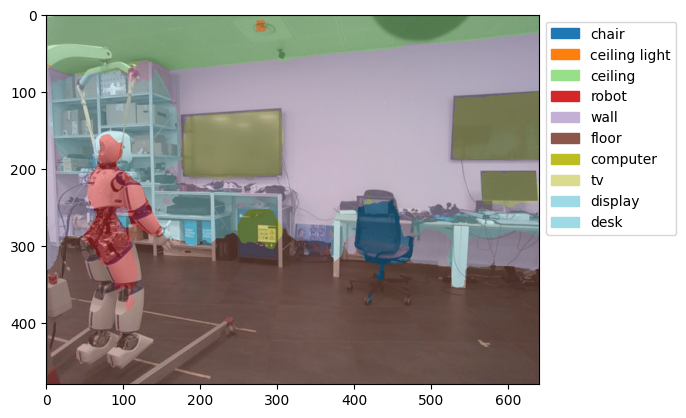

['chair', 'ceiling light', 'ceiling', 'robot', 'wall', 'floor', 'computer', 'tv', 'display', 'desk']


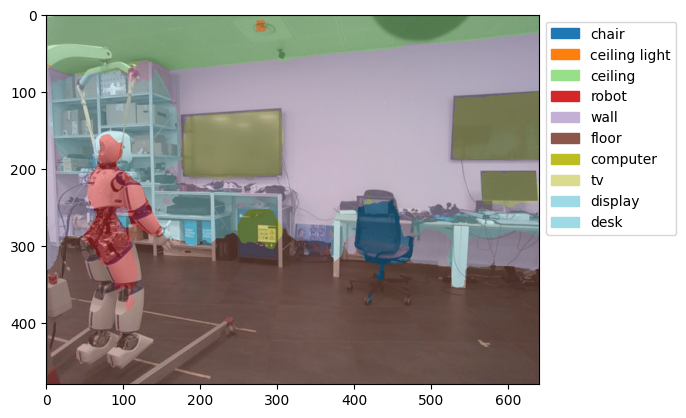

In [12]:
# visualize the output as a segmentation mask

import matplotlib.pyplot as plt
import numpy as np
import cv2

indexes = range(0, 2)
for index in indexes:
    sample = ds[0]

    image = sample['image'].permute(1, 2, 0).numpy()

    label_index_to_color_dict = {i : plt.cm.get_cmap('tab20')(i) for i in range(len(labels))}

    outputs = output_list[index]
    mask = outputs[0]['sem_seg'].cpu().numpy()
    mask = np.argmax(mask, axis=0)
    # rearrange the mask to match the original image shape
    # mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # iterate over the mask pixels and assign the color to the corresponding label
    mask_color = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.float64)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            mask_color[i, j] = label_index_to_color_dict[mask[i, j]]

    mask_color[0][0]

    detected = [labels[i] for i in np.unique(mask)]
    print(detected)

    plt.imshow(image)
    plt.imshow(mask_color, alpha=0.5)

    # place legend outside the plot
    plt.legend(handles=[plt.Rectangle((0,0),1,1, color=label_index_to_color_dict[i], label=labels[i]) for i in np.unique(mask)], loc='upper left', bbox_to_anchor=(1, 1))

    assert image.shape[:2] == mask.shape == mask_color.shape[:2], (image.shape[:2], mask.shape, mask_color.shape[:2])

    plt.show()
